# Theoretical Framework for Linear Bayesian Regressions


Objective:  I am writing this script to synthesise and better understand some concept I learnt by myself


## Framework:

### PART 1:

I will generate a vector of training dataset from a sin function. Then using this training data set I will do a linear regression using SSE.Then find the optimal model that best fits- changing the hyperparameters and computing the magnitude of error for each model using a testing dataset. And finally examine overfitting (Eventually computing the ridge regression if needed).

### PART 2:

I will prove: both the SSE and the Ridge Regression using the maximum likihood estimator for a linear regression

### PART 3:

I will find the predictive posterior distribution and conjugate prior..

### PART 4:

Monte carlo and markov chain.

### PART 5:
Replicate using multivariate linear regression

## Part 1 :
I will start by drawing by noisy dataset generated from a sin function

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures


In [153]:
np.random.seed(0)
def population_function(x):
    return np.sin(np.pi*2*x)

def noisy_dataset_generator(x):
    y =population_function(x) + np.random.normal(0,0.25,x.size) #adding noise using normally dist errors
    return y

N = 20    #number of training datapoints
x_train = np.linspace(0,1,N)  #vector of N xcoords (training data points). All x are between 0 and 1.
y_train = noisy_dataset_generator(x_train)

 

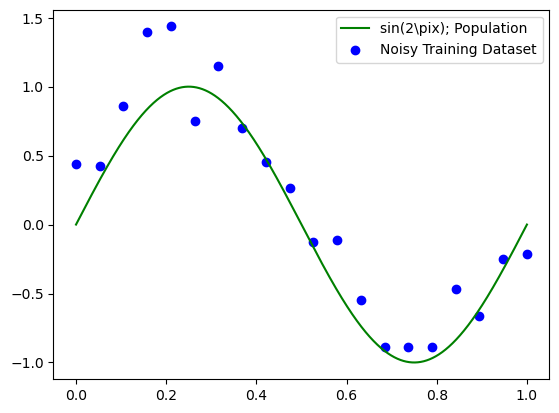

In [106]:
x_plot = np.arange(0,1.0001,0.0001) #steps are small to be able to draw it 
y_plot = population_function(x_plot)
plt.plot(x_plot,y_plot,color='g',label="sin(2\pix); Population")
plt.scatter(x_train,y_train,marker ="o", color = "b", label = "Noisy Training Dataset")
plt.legend()
plt.show()


### Now, let's find the best model

I will plot the regression line using SSE for differrent orders polynomials (i.e. different models):
(The model is linear and univariate)

In [126]:
#I want a matrix of different polynomial orders 
'''   
This function gives us a matrix (n,m+1) : for each training x in X, I will get 
x^0 x^1 x^2 ... x^m ; m being the order we model 
abour reshape(-1,1): The function fit_transform works only for X=[[a],[b],....,[c]]
i.e. it only works for (n,1) matrices 
We transform our X to (n,1), by reshaping 
the "-1" in reshape automatically transforms column to size(X)

'''
def poly_given_order(X,m):  
    return PolynomialFeatures(degree=m).fit_transform(X.reshape(-1,1))
predictors_m0= poly_given_order(x_train,0)
predictors_m6 = poly_given_order(x_train,6)
predictors_m10 = poly_given_order(x_train,10)
predictors_m20 = poly_given_order(x_train,20)




In [173]:
#I want to compute weights using SSE:
#W= (X'X)X'y
def compute_weight(X,y):
    W = np.linalg.inv(np.transpose(X)@X)@np.transpose(X)@y
    return W

#I want to compute the predicted target variable - (n,1) vector : yhat=WX
def compute_target(W,X):
    yhat = X@W
    return yhat


Let's now compute everything using my functions

In [212]:
w_m0 = compute_weight(predictors_m0,y_train) #weight vector for model 0
yhat_m0= compute_target(w_m0,predictors_m0) #estmiated target vector for model 0

w_m6 = compute_weight(predictors_m6,y_train)
yhat_m6= compute_target(w_m6,predictors_m6)

w_m10 = compute_weight(predictors_m10,y_train)
yhat_m10= compute_target(w_m10,predictors_m10)

w_m20 = compute_weight(predictors_m20,y_train)
yhat_m20= compute_target(w_m20,predictors_m20)

est_weights = [w_m0,w_m6,w_m10,w_m20]
yhats = [yhat_m0,yhat_m6,yhat_m10,yhat_m20]



I want to plot each model individually

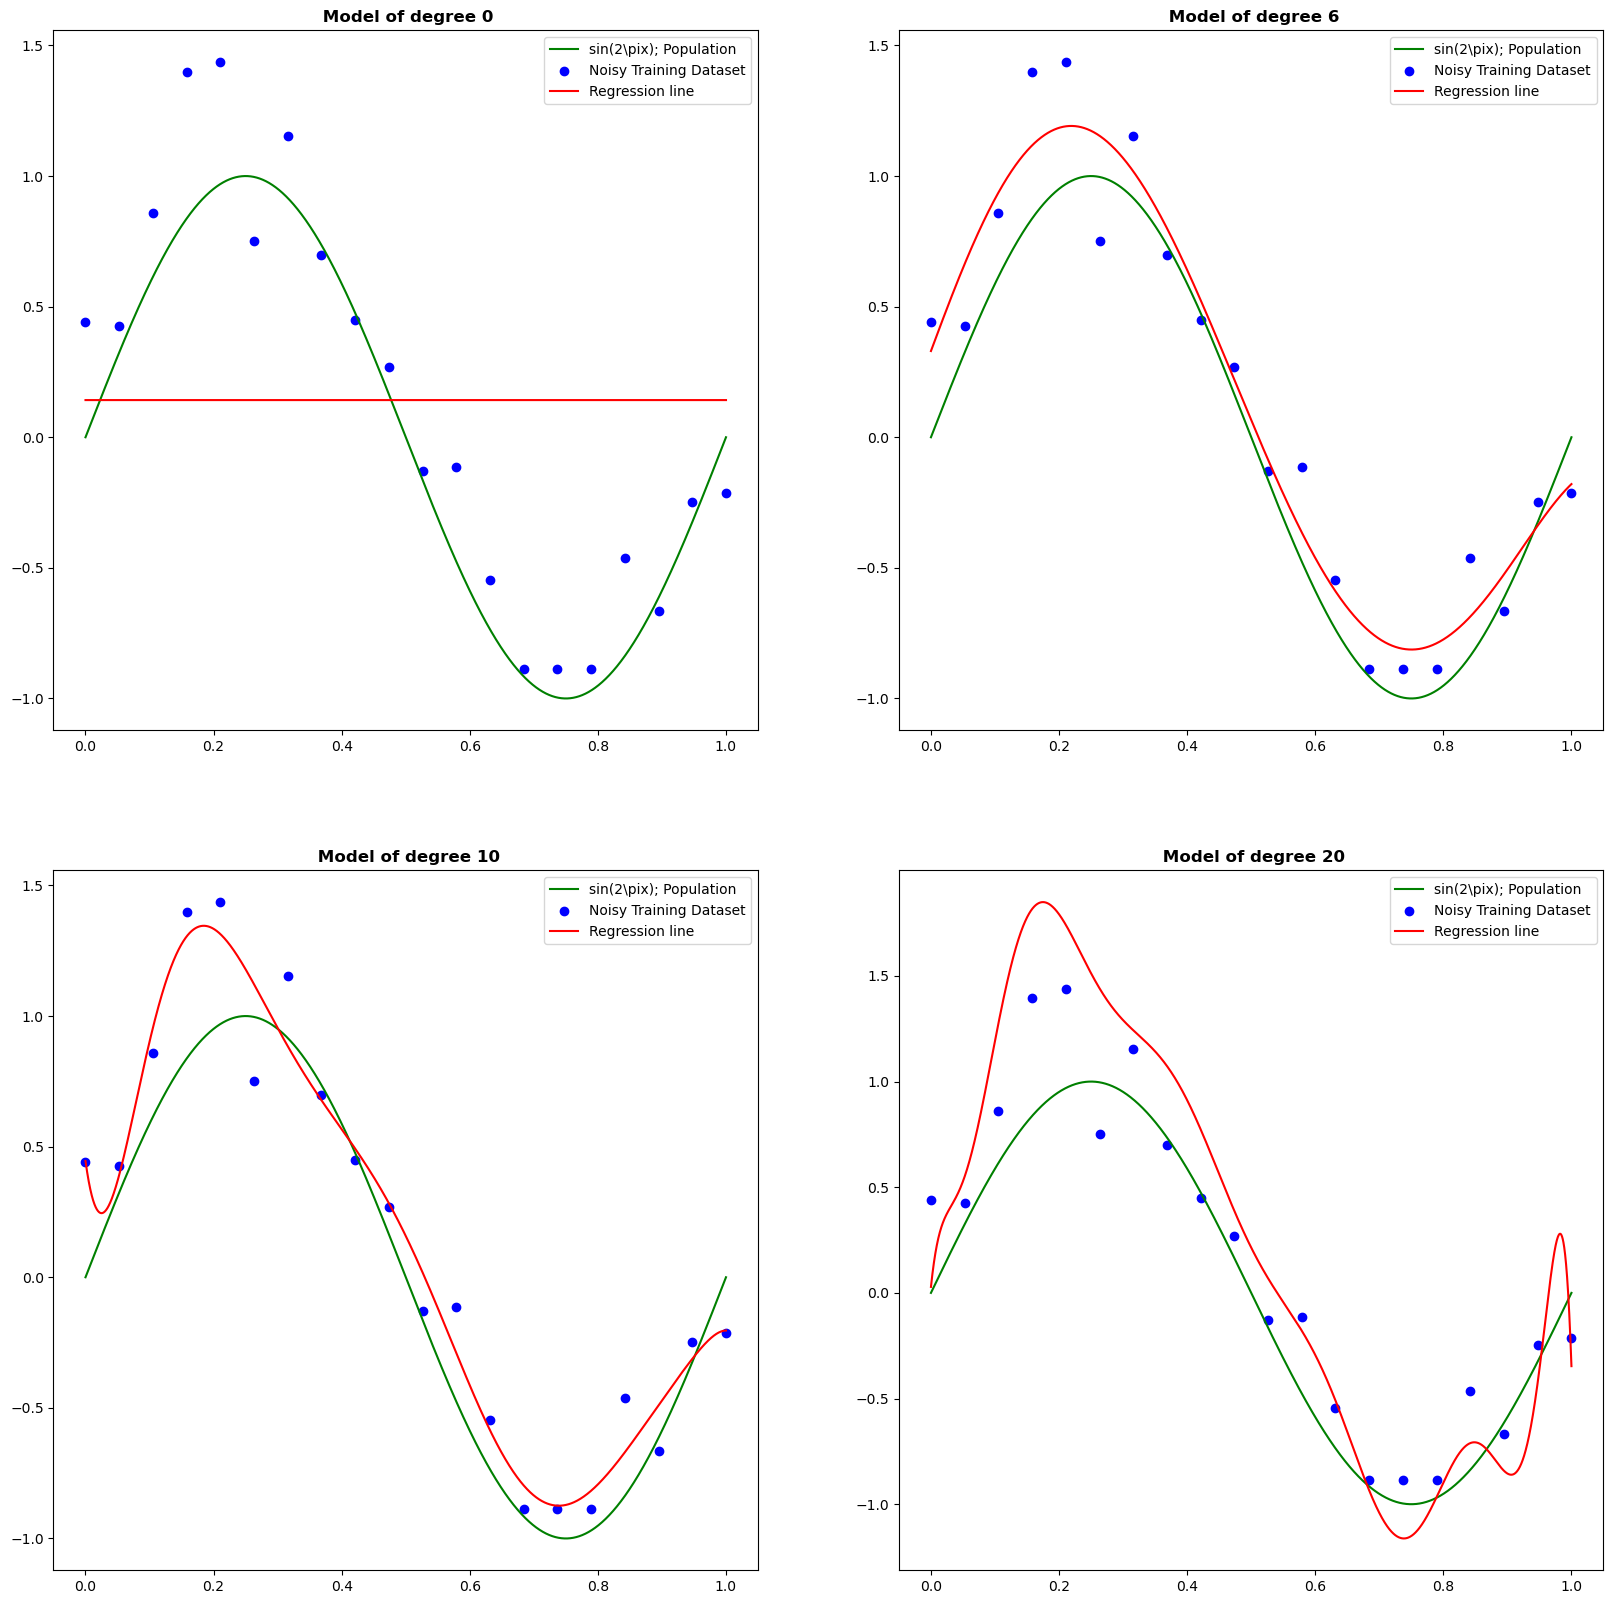

In [213]:
fig , ax = plt.subplots( nrows = 2 , ncols = 2 , figsize= (20,20))
for i in range(len(est_weights)):
    row_ax = i //2 
    col_ax = i%2 
    x_plot = np.arange(0,1.0001,0.0001) #steps are small to be able to draw it 
    y_plot = population_function(x_plot)
    ax[row_ax,col_ax].plot(x_plot,y_plot,color='g',label="sin(2\pix); Population")
    ax[row_ax,col_ax].scatter(x_train,y_train,marker ="o", color = "b", label = "Noisy Training Dataset")

    X = np.column_stack([np.power(x_plot, i) for i in range(est_weights[i].shape[0])])  # create the design matrix
    y = X @ est_weights[i]  # compute the predicted values
    
    # plot the line with the weights of w_m6
    ax[row_ax,col_ax].plot(x, y, label='Regression line', color='r')
    ax[row_ax, col_ax].legend()
    titre= " Model of degree " + str(est_weights[i].shape[0] -1 )
    ax[row_ax, col_ax].set_title(titre , fontweight= 'bold')


## Two interesting models :
#### Model 6 best fits the population function.
#### Model 10  best fits the training dataset.

## CRITERIA TO LOOK FOR : ROOT SQUARED MEAN
#### I need to check how the model is going to perferm for a testing dataset .
#### I should test the error function  E(W*) = 1/2  Σ(f(xi,w*) - ti)^2  for the testing dataset
### Modify error to the root squared mean: sqrt(2E(W*)/N)
#### I take the average because I want to compare across different datasets that might have different sizes 
#### I take the sqrt because I want it to have the same scale as the target variable
#### I multiply by 2 to cancel out the 1/2

In [227]:
x_test = np.random.rand(20)   # shape ( 20, 1)
y_test =  noisy_dataset_generator(x_test)  # shape ( 20 m1)

#print(est_weights[2].reshape(-1,1).shape)
#print(est_weights[2].shape[0]  -1  )
yhats_test = [] 
for i in range(4):
    x_test_polynomial = poly_given_order(x_test,est_weights[i].shape[0] -1 )
    
    yhats_test.append( compute_target(est_weights[i].reshape(-1,1),x_test_polynomial))
    
yhats_test = np.array(yhats_test)

In [228]:

def rsm(yhat , y):
    mse=[] #mean squared error for each model 
    error = 0 # used in loop for summing 
    for i in range(len(est_weights)):
        for j in range(20):
            error += (yhat[i][j] - y[j] )**2
        error = 0.5 *error 
        mse.append(error)
        error = 0

    #I want to convert from list to np in order to transform mse to rsm :
    mse_arr = np.array(mse) #mse in numpy array form instead of list 
    rsm = np.sqrt(mse_arr*2/N)        #root squared mean
    return rsm
rsm_test = rsm(yhats_test,y_test) #rsm applied on testing dataset 
rsm_train = rsm(yhats, y_train) #rsm applied on trainin dataset 

In [235]:
rsm_test

array([[0.84594139],
       [0.26025775],
       [0.26778477],
       [0.41383802]])

In [232]:
rsm_train

array([0.73566796, 0.17239986, 0.13972814, 0.28656194])

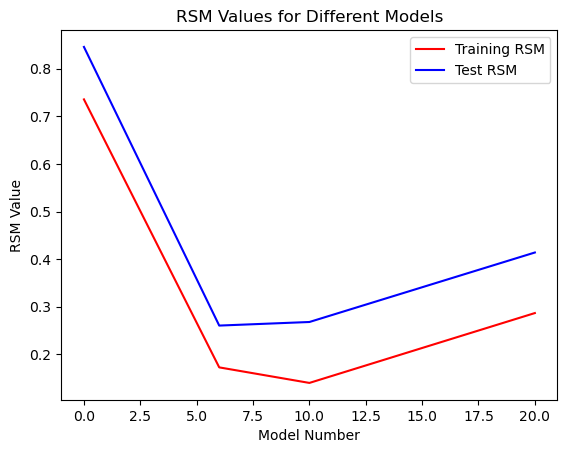

In [236]:
import matplotlib.pyplot as plt

models = [0, 6, 10, 20]
plt.plot(models, rsm_train, 'r', label='Training RSM')
plt.plot(models, rsm_test, 'b', label='Test RSM')
plt.legend()
plt.xlabel('Model Number')
plt.ylabel('RSM Value')
plt.title('RSM Values for Different Models')
plt.show()


In [237]:
# Perform linear regression for different polynomial degrees
weight_vectors = {}
for m in [0, 1, 3, 9]:
    weight_vectors[f'M={m}'] = regress(m=m, x=x_train, y=y_train)
    
# Pad weight vectors to have same dimension for display
def pad_weight_vectors(weight_vector):
    while len(weight_vector) <= 9:
        weight_vector = np.append(weight_vector, 0.)
    return weight_vector

df = pd.DataFrame([pad_weight_vectors(weight_vectors[m]) for m in weight_vectors]).transpose()
df.columns = [m for m in weight_vectors]

# Display weight vectors as a pandas dataframe
df


NameError: name 'regress' is not defined

In [238]:
n_values = [10, 50, 100, 500, 1000]  # Dataset sizes to try
m_values = [1, 3, 5, 7]             # Polynomial degrees to try

train_mse = {}  # Dictionary to store train MSE for each m and n
val_mse = {}    # Dictionary to store validation MSE for each m and n

for n in n_values:
    # Generate training and validation data
    x_train, y_train = generate_data(n, f=func, noise_scale=0.1)
    x_val, y_val = generate_data(n, f=func, noise_scale=0.1)

    for m in m_values:
        # Perform linear regression on training data
        w = regress(m, x_train, y_train)

        # Calculate train MSE
        y_pred_train = predict(w, x_train)
        mse_train = mean_squared_error(y_train, y_pred_train)
        train_mse[(m, n)] = mse_train

        # Calculate validation MSE
        y_pred_val = predict(w, x_val)
        mse_val = mean_squared_error(y_val, y_pred_val)
        val_mse[(m, n)] = mse_val

# Plot results
fig, axs = plt.subplots(len(m_values), 1, figsize=(8, 12), sharex=True, sharey=True)
for i, m in enumerate(m_values):
    axs[i].set_title(f'M={m}')
    axs[i].set_ylabel('MSE')
    axs[i].plot(n_values, [train_mse[(m, n)] for n in n_values], label='Train')
    axs[i].plot(n_values, [val_mse[(m, n)] for n in n_values], label='Validation')
    axs[i].legend()
plt.xlabel('Dataset size')
plt.show()


NameError: name 'generate_data' is not defined

             alpha=0  alpha=0.01  alpha=0.1   alpha=1  alpha=10
degree                                                         
0           1.082258    1.082258   1.082258  1.082258  1.082258
1           0.279775    0.279424   0.276368  0.254878  0.348604
3           0.518983    0.622421   1.130038  0.729164  0.339061
9       84124.216867    0.561635   2.504249  1.099140  0.323903


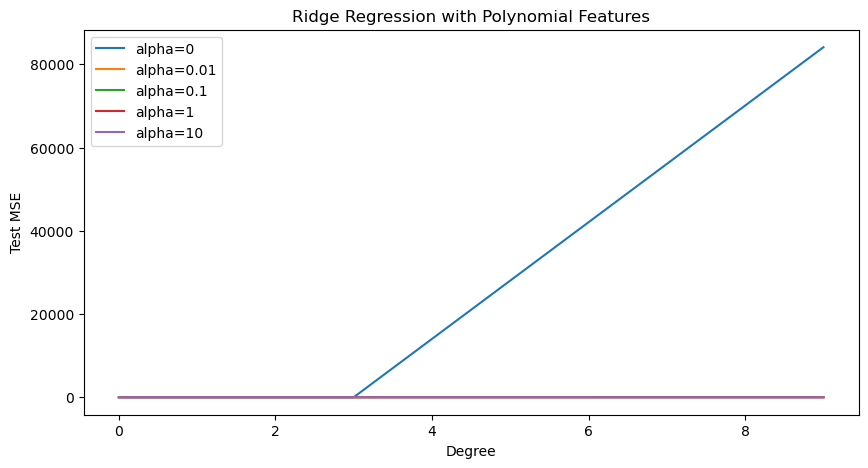

In [239]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generate some random data
np.random.seed(42)
x = np.linspace(-1, 1, 100)
y = np.sin(np.pi*x) + np.random.normal(scale=0.1, size=100)

# Split the data into training and test sets
x_train, x_test = x[:70], x[70:]
y_train, y_test = y[:70], y[70:]

# Define a function to perform polynomial regression with a given degree
def polynomial_regression(degree, x_train, y_train, x_test, y_test, alpha=0):
    poly = PolynomialFeatures(degree)
    X_train = poly.fit_transform(x_train.reshape(-1, 1))
    X_test = poly.fit_transform(x_test.reshape(-1, 1))
    
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    
    return train_mse, test_mse

# Test polynomial regression with different degrees and regularization parameters
degrees = [0, 1, 3, 9]
alphas = [0, 0.01, 0.1, 1, 10]

results = []

for degree in degrees:
    for alpha in alphas:
        train_mse, test_mse = polynomial_regression(degree, x_train, y_train, x_test, y_test, alpha=alpha)
        results.append({'degree': degree, 'alpha': alpha, 'train_mse': train_mse, 'test_mse': test_mse})
        
# Display the results in a Pandas dataframe
results_df = pd.DataFrame(results)
results_df = results_df.pivot(index='degree', columns='alpha', values='test_mse')
results_df.columns = [f'alpha={alpha}' for alpha in alphas]
print(results_df)

# Plot the results
plt.figure(figsize=(10, 5))

for alpha in alphas:
    plt.plot(degrees, results_df[f'alpha={alpha}'], label=f'alpha={alpha}')

plt.title('Ridge Regression with Polynomial Features')
plt.xlabel('Degree')
plt.ylabel('Test MSE')
plt.legend()
plt.show()
